# Quantitative Trading Simulation Framework
## A Time Series-Based Approach to Financial Engineering

**Author:** Conrad  
**Purpose:** Educational framework for graduate-level financial engineering students  
**Focus:** Time-save quantitative stock trading simulations using modern Python tools

### Learning Objectives:
1. **Time Series Simulation**: Master rolling-window backtesting for realistic strategy evaluation
2. **xarray for Research**: Organize multi-dimensional financial data and results efficiently  
3. **sklearn Pipelines**: Build robust, reproducible ML workflows for finance
4. **Performance Analytics**: Extract meaningful statistics over time for strategy evaluation

### What You'll Learn:
- How to structure proper time series simulations that avoid look-ahead bias
- The value of xarray for organizing research results across multiple dimensions
- Best practices for sklearn pipelines in financial contexts
- Integration of statsmodels with sklearn for enhanced statistical analysis
- Performance measurement and risk assessment over time

---

<a href="https://colab.research.google.com/github/Cerebellum-Archive/capstone_simulator/blob/main/Stock_Sim_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Section 1: Environment Setup
# 1.1 Working Directory Check
# This cell helps ensure you're in the correct working directory for the simulation.

import os
print(f"Current working directory: {os.getcwd()}")



/content


In [2]:
# 1.2 Google Colab Drive Mount (Optional)
# Uncomment these lines if running in Google Colab and need access to Google Drive files.

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


In [3]:
# Section 2: Library Imports and Configuration
# 2.1 Core Libraries for Financial Engineering

# Metadata
Author = 'Conrad'

# Suppress warnings for cleaner output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# === TIME HANDLING ===
# Critical for time series analysis - all timestamps must be handled consistently
from datetime import datetime
import time
import pytz
local_timezone = 'America/Los_Angeles'  # Market timezone for NYSE/NASDAQ
from time import gmtime, strftime

# === CORE DATA SCIENCE STACK ===
from scipy import stats
import numpy as np
import pandas as pd
import pickle

# === XARRAY: THE SECRET WEAPON FOR FINANCIAL RESEARCH ===
# xarray is incredibly powerful for organizing multi-dimensional financial data
# Think: [time x assets x strategies x risk_metrics] all in one structure
import xarray as xr
from pandas import Series

# === VISUALIZATION ===
import seaborn as sns
from IPython.display import display  # Enhanced DataFrame display
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0)  # Larger plots for better readability

# === FINANCIAL DATA ===
import yfinance as yf  # Industry standard for getting market data

# === SKLEARN: MACHINE LEARNING FOR FINANCE ===
# Preprocessing tools
from sklearn import preprocessing
from sklearn.preprocessing import (
    FunctionTransformer, maxabs_scale, MinMaxScaler, 
    Binarizer, StandardScaler, PowerTransformer
)

# Feature engineering and selection
from sklearn.decomposition import FastICA, PCA
from sklearn.feature_selection import (
    SelectKBest, chi2, f_regression, 
    mutual_info_regression, r_regression
)

# Models (both traditional and ensemble)
from sklearn import cluster, tree
from sklearn.linear_model import (
    LinearRegression, Ridge, ElasticNet, Lasso, 
    ElasticNetCV, HuberRegressor, RidgeCV
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn import mixture

# Model evaluation metrics
from sklearn.metrics import (
    mean_squared_error as rmse, mean_absolute_error as mae,
    explained_variance_score as evs, r2_score as r_squared,
    confusion_matrix, classification_report
)

# Pipeline construction (KEY for reproducible research)
from sklearn.pipeline import Pipeline, make_pipeline, clone
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.dummy import DummyRegressor
from sklearn.multioutput import MultiOutputRegressor

# === STATSMODELS: ECONOMETRIC ANALYSIS ===
# Essential for financial statistics and econometric modeling
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

# === SCIPY STATISTICAL TOOLS ===
from scipy.stats.mstats import winsorize  # Outlier handling
from scipy.stats import norm  # Normal distribution utilities

# === LIGHTGBM (Optional Advanced Model) ===
try:
    from lightgbm import LGBMClassifier as lgb
except ImportError:
    print("LightGBM not available - install with: pip install lightgbm")

# === SKLEARN CONFIGURATION ===
# This makes sklearn display pipeline diagrams
from sklearn import set_config
set_config(display="diagram")

# === GLOBAL SCALERS ===
# Pre-configured scaler for convenience (outputs pandas DataFrames)
zscaler = StandardScaler().set_output(transform='pandas')

# === TIMING FOR PERFORMANCE MONITORING ===
last_printed_time = datetime.now()

print("✓ All libraries imported successfully!")
print(f"✓ Author: {Author}")
print(f"✓ Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


In [4]:
# Section 3: Core Utility Functions
# The following functions are the building blocks for our time series simulation framework. 
# Understanding these is crucial for mastering quantitative finance simulations.

# Note: This section would typically contain custom utility functions
# The actual utility functions are defined in the next cell
pass

In [5]:
# 3.1 Utility Functions for Time Series Financial Simulation

def simplify_teos(df):
    """
    Time of Effective Observation (TEO) Simplification
    
    Purpose: Convert timezone-aware datetime index to simplified date format
    This is crucial for time series alignment in financial simulations
    
    Args:
        df: DataFrame with timezone-aware datetime index
    
    Returns:
        df: DataFrame with simplified date index (no timezone, normalized to midnight)
    
    Why this matters: Financial data often comes with timezone info, but for
    backtesting we usually want simple date alignment across different data sources
    """
    df.index = df.index.tz_localize(None).normalize()
    return df

def log_returns(df):
    """
    Calculate Log Returns
    
    Log returns are the industry standard for financial analysis because:
    1. They're additive over time: log_ret(t1,t3) = log_ret(t1,t2) + log_ret(t2,t3)
    2. They're approximately equal to simple returns for small changes
    3. They're more suitable for statistical modeling (closer to normal distribution)
    
    Formula: log_return(t) = ln(price(t)) - ln(price(t-1))
    
    Args:
        df: DataFrame of price data
    
    Returns:
        df: DataFrame of log returns (first row will be NaN)
    """
    df = np.log(df)
    df = df - df.shift(1)
    return df

def L_func_2(df, pred_col='predicted', params=[]):
    """
    Simple Binary Position Sizing Function
    
    This function converts predictions into trading positions based on sign:
    - If prediction <= 0: take params[0] position (typically negative/short)
    - If prediction > 0: take params[1] position (typically positive/long)
    
    Args:
        df: DataFrame containing predictions
        pred_col: Name of prediction column
        params: [negative_position, positive_position] e.g., [-1, 1] for full long/short
    
    Returns:
        Array of position sizes
    """
    t_conditions = [df[pred_col] <= 0, df[pred_col] > 0]
    t_positions = [params[0], params[1]]
    return np.select(t_conditions, t_positions, default=np.nan)

def L_func_3(df, pred_col='preds_index', params=[]):
    """
    Quartile-Based Position Sizing Function
    
    More sophisticated position sizing using prediction percentiles:
    - Bottom quartile (0-25%): params[0] position
    - Second quartile (25-50%): params[1] position  
    - Third quartile (50-75%): params[2] position
    - Top quartile (75-100%): params[3] position
    
    This allows for more nuanced position sizing based on prediction confidence
    
    Args:
        df: DataFrame with normalized predictions (0-1 scale)
        pred_col: Column name for predictions
        params: [pos1, pos2, pos3, pos4] for each quartile
    
    Returns:
        Array of position sizes
    """
    t_conditions = [
        (df[pred_col].between(0.00, 0.25)),
        (df[pred_col].between(0.25, 0.50)),
        (df[pred_col].between(0.50, 0.75)),
        (df[pred_col].between(0.75, 1.00))
    ]
    t_positions = params
    return np.select(t_conditions, t_positions, default=np.nan)

def L_func_4(ds, params=[]):
    """
    Alternative Quartile Position Sizing (Series Version)
    
    Same logic as L_func_3 but operates directly on a Series
    Useful for applying position logic to individual prediction series
    """
    t_conditions = [
        (ds.between(0.00, 0.25)),
        (ds.between(0.25, 0.50)),
        (ds.between(0.50, 0.75)),
        (ds.between(0.75, 1.00))
    ]
    t_positions = params
    return np.select(t_conditions, t_positions, default=np.nan)

print("✓ Position sizing functions loaded successfully!")
print("  - simplify_teos(): TEO normalization")
print("  - log_returns(): Financial return calculation") 
print("  - L_func_2(): Binary position sizing")
print("  - L_func_3(): Quartile position sizing")
print("  - L_func_4(): Series quartile positioning")

In [6]:

# 3.2 Performance Analytics and Feature Analysis Functions

def sim_stats(regout_list, sweep_tags, author='CG', trange=None):
    """
    Comprehensive Simulation Statistics Calculator
    
    This is the cornerstone function for evaluating trading strategy performance.
    It calculates all the key metrics that quantitative analysts care about.
    
    Key Metrics Computed:
    - Annualized Return & Volatility (252 trading days assumption)
    - Sharpe Ratio (risk-adjusted returns)
    - Average Leverage/Beta
    - Prediction Accuracy Metrics (RMSE, MAE, R²)
    - Benchmark Comparisons
    
    Args:
        regout_list: List of DataFrames with simulation results
        sweep_tags: List of strategy names/labels
        author: Analyst name for record keeping
        trange: Time range slice for analysis
    
    Returns:
        DataFrame with comprehensive performance statistics
    """
    df = pd.DataFrame()
    df.index.name = 'metric'
    print('SIMULATION RANGE:', 'from', trange.start, 'to', trange.stop)
    
    for n, testlabel in enumerate(sweep_tags):
        reg_out = regout_list[n].loc[trange, :]
        
        # === PERFORMANCE METRICS ===
        df.loc['return', testlabel] = mean = 252 * reg_out.perf_ret.mean()
        df.loc['stdev', testlabel] = std = (np.sqrt(252)) * reg_out.perf_ret.std()
        df.loc['sharpe', testlabel] = mean / std if std != 0 else np.nan
        
        # === POSITION SIZING METRICS ===
        df.loc['avg_beta', testlabel] = reg_out.leverage.mean()
        df.loc['beta_1_return', testlabel] = (df.loc['return', testlabel] / 
                                             reg_out.leverage.mean() if reg_out.leverage.mean() != 0 else np.nan)
        
        # === PREDICTION ANALYSIS ===
        valid_preds = np.isfinite(reg_out['prediction'])
        df.loc['pos_bet_ratio', testlabel] = (
            np.sum(valid_preds & (reg_out['prediction'] > 0)) / 
            np.sum(valid_preds) if np.sum(valid_preds) > 0 else np.nan
        )
        
        # === MODEL PERFORMANCE ===
        df.loc['rmse', testlabel] = np.sqrt(rmse(reg_out.prediction, reg_out.actual))
        df.loc['mae', testlabel] = mae(reg_out.prediction, reg_out.actual)
        df.loc['r2', testlabel] = r_squared(reg_out.actual, reg_out.prediction)
        
        # === BENCHMARK COMPARISON ===
        df.loc['benchmark return', testlabel] = bench_ret = 252 * reg_out.actual.mean()
        df.loc['benchmark std', testlabel] = bench_std = (np.sqrt(252)) * reg_out.actual.std()
        df.loc['benchmark sharpe', testlabel] = bench_ret / bench_std if bench_std != 0 else np.nan
        
        # === METADATA ===
        df.loc['beg_pred', testlabel] = min(reg_out.prediction.index).date()
        df.loc['end_pred', testlabel] = max(reg_out.prediction.index).date()
        df.loc['sim_time', testlabel] = datetime.now(pytz.timezone(local_timezone)).strftime("%x %-I:%-m%p")
        df.loc['author', testlabel] = author
        
    return df

def p_by_slice(X, y, t_list, t_list_labels):
    """
    Feature Significance Analysis by Time Slices
    
    Analyzes how feature importance changes across different time periods.
    Critical for understanding regime changes in financial markets.
    
    Args:
        X: Feature matrix
        y: Target variable
        t_list: List of time slice indices
        t_list_labels: Labels for each time slice
    
    Returns:
        DataFrame with correlation statistics for each time slice
    """
    feat_stats = pd.DataFrame(index=X.columns)
    
    for n, idx in enumerate(t_list):
        X_fit = X.loc[idx, :].dropna()
        y_fit = y.reindex(X_fit.index)
        feat_stats.loc[:, t_list_labels[n]] = r_regression(X_fit, y_fit, center=True)
    
    print('Analysis period: from', X_fit.index.min(), 'to', X_fit.index.max())
    return feat_stats

def p_by_year(X, y, sort_by='p_value', t_list=None):
    """
    Annual Feature Analysis
    
    Breaks down feature correlations by calendar year to identify:
    - Secular trends in factor effectiveness
    - Regime changes
    - Market cycle dependencies
    
    This is essential for understanding when your models work and when they don't.
    
    Args:
        X: Feature matrix
        y: Target variable
        sort_by: Column to sort results by
        t_list: Optional specific time periods (unused in current implementation)
    
    Returns:
        DataFrame with annual correlation statistics
    """
    feat_stats = pd.DataFrame(index=X.columns)
    
    for year in X.index.year.unique():
        X_fit = X.loc[str(year), :].dropna()
        y_fit = y.reindex(X_fit.index)
        feat_stats.loc[:, str(year)] = r_regression(X_fit, y_fit, center=True)
    
    print('Analysis period: from', X_fit.index.min(), 'to', X_fit.index.max())
    return feat_stats

print("✓ Performance analytics functions loaded!")
print("  - sim_stats(): Comprehensive performance evaluation")
print("  - p_by_slice(): Time-slice feature analysis") 
print("  - p_by_year(): Annual feature breakdown")

# 3.3 Advanced Analytics and Simulation Infrastructure

def feature_profiles(X, y, sort_by='pearson', t_slice=None):
    """
    Comprehensive Feature Analysis Suite
    
    This function provides multiple statistical tests for feature evaluation:
    - Pearson correlation (linear relationships)
    - Mutual information (non-linear relationships)  
    - F-statistics and p-values (statistical significance)
    - T-statistics (hypothesis testing)
    
    Critical for understanding which features drive your model performance.
    
    Args:
        X: Feature matrix
        y: Target variable
        sort_by: Metric to sort features by
        t_slice: Optional time slice for analysis
    
    Returns:
        DataFrame with comprehensive feature statistics, sorted by chosen metric
    """
    if not t_slice:
        t_slice = slice(X.index.min(), X.index.max())
        print(f"Analyzing full time range: {t_slice}")
    
    # Prepare data for analysis
    if t_slice is not None:
        X_fit = X.loc[t_slice, :].dropna()
        y_fit = y.reindex(X_fit.index)
    else:
        X_fit = X.copy()
        y_fit = y.copy()
    
    # Statistical tests
    pear_test = r_regression(X_fit, y_fit, center=True)
    abs_pear_test = np.abs(pear_test)
    f_test, p_value = f_regression(X_fit, y_fit, center=False)
    t_test = np.sqrt(f_test) / np.sqrt(1)
    mi = mutual_info_regression(X_fit, y_fit)
    nobs = len(X_fit)
    
    feat_stats = pd.DataFrame({
        'nobs': nobs,
        'mutual_info': mi,
        'p_value': p_value,
        't_test': t_test,
        'pearson': pear_test,
        'abs_pearson': abs_pear_test
    }, index=X.columns)
    
    print(f'Analysis period: from {X_fit.index.min()} to {X_fit.index.max()}')
    return feat_stats.sort_values(by=[sort_by], ascending=False)

def generate_train_predict_calender(df, window_type=None, window_size=None):
    """
    Time Series Cross-Validation Calendar Generator
    
    This is THE most important function for proper time series simulation.
    It generates training/prediction date pairs while respecting temporal order.
    
    Two modes:
    1. 'fixed': Rolling window of constant size (good for stationary periods)
    2. 'expanding': Growing window from start (captures long-term trends)
    
    CRITICAL: This prevents look-ahead bias by ensuring we only use past data
    to predict future returns.
    
    Args:
        df: DataFrame with datetime index
        window_type: 'fixed' or 'expanding'
        window_size: Number of periods for initial training window
    
    Returns:
        List of [train_start, train_end, prediction_date] tuples
    """
    date_ranges = []
    index = df.index
    num_days = len(index)
    
    if window_type == 'fixed':
        # Rolling window: train on last N days, predict next day
        for i in range(window_size, num_days):
            train_start_date = index[i - window_size]
            train_end_date = index[i - 1]
            prediction_date = index[i]
            date_ranges.append([train_start_date, train_end_date, prediction_date])
    
    elif window_type == 'expanding':
        # Expanding window: train from start to current, predict next day
        for i in range(window_size, num_days):
            train_start_date = index[0]
            train_end_date = index[i - 1]
            prediction_date = index[i]
            date_ranges.append([train_start_date, train_end_date, prediction_date])
    
    print(f"✓ Generated {len(date_ranges)} train/predict pairs using {window_type} window")
    return date_ranges

def graph_df(df, w=10, h=15):
    """
    Quick Multi-Series Plotting Function
    
    Useful for rapidly visualizing multiple time series in a DataFrame.
    Each column gets its own subplot for easy comparison.
    
    Args:
        df: DataFrame with time series data
        w: Figure width
        h: Figure height
    """
    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(w, h))
    
    # Handle single column case
    if len(df.columns) == 1:
        axes = [axes]
    
    # Plot each column
    for i, col in enumerate(df.columns):
        axes[i].plot(df.index, df[col], linewidth=1.2)
        axes[i].set_title(f"{col}", fontsize=12, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

print("✓ Advanced analytics functions loaded!")
print("  - feature_profiles(): Comprehensive feature analysis")
print("  - generate_train_predict_calender(): Time series CV calendar") 
print("  - graph_df(): Multi-series visualization")

# 3.4 Custom sklearn Components for Financial Modeling

class StatsModelsWrapper_with_OLS(BaseEstimator, RegressorMixin):
    """
    sklearn-Compatible Wrapper for StatsModels OLS
    
    This class bridges the gap between sklearn's pipeline framework and 
    statsmodels' rich econometric capabilities. It allows you to:
    
    1. Use OLS within sklearn pipelines
    2. Access detailed statistical summaries
    3. Get proper econometric diagnostics
    4. Maintain sklearn's fit/predict interface
    
    Why this matters: sklearn focuses on prediction, but financial analysis
    often requires understanding statistical significance, confidence intervals,
    and econometric diagnostics that statsmodels provides.
    """
    
    def __init__(self, exog=None, endog=None):
        """
        Initialize the wrapper
        
        Args:
            exog: Explanatory variables (features) - kept for compatibility
            endog: Dependent variable (target) - kept for compatibility
        """
        self.exog = exog
        self.endog = endog
        self.model_ = None
        self.results_ = None

    def fit(self, X_fit, y_fit):
        """
        Fit OLS model with automatic constant addition
        
        Args:
            X_fit: Training features
            y_fit: Training targets
        
        Returns:
            self: Fitted estimator
        """
        # OLS requires a constant term for proper intercept estimation
        X_with_const = add_constant(X_fit, has_constant='add')
        self.model_ = OLS(y_fit, X_with_const)
        self.results_ = self.model_.fit()
        return self

    def predict(self, X_pred):
        """
        Generate predictions using fitted model
        
        Args:
            X_pred: Features for prediction
        
        Returns:
            Array of predictions
        """
        X_pred_constant = add_constant(X_pred, has_constant='add')
        return self.results_.predict(X_pred_constant)

    def summary(self, title=None):
        """
        Access detailed econometric summary
        
        This is the key advantage over pure sklearn - you get:
        - Coefficient significance tests
        - R-squared and adjusted R-squared
        - F-statistics
        - Confidence intervals
        - Diagnostic tests
        
        Args:
            title: Optional title for the summary table
        
        Returns:
            StatsModels summary object
        """
        if title is not None:
            return self.results_.summary(title=title)
        else:
            generic_title = "OLS Regression Results"
            return self.results_.summary(title=generic_title)


class EWMTransformer(BaseEstimator, TransformerMixin):
    """
    Exponentially Weighted Moving Average Transformer
    
    Exponential smoothing is crucial in finance because:
    1. Recent data points get more weight (market regime changes)
    2. Reduces noise while preserving trends
    3. Adapts faster to structural breaks than simple moving averages
    
    The halflife parameter controls decay rate:
    - Smaller halflife = faster adaptation, more noise
    - Larger halflife = smoother, slower adaptation
    
    Formula: EWM(t) = α * X(t) + (1-α) * EWM(t-1)
    where α = 1 - exp(-ln(2)/halflife)
    """
    
    def __init__(self, halflife=3):
        """
        Initialize the transformer
        
        Args:
            halflife: Number of periods for value to decay to 50%
                     halflife=1 → very responsive
                     halflife=10 → very smooth
        """
        self.halflife = halflife
        self.output_as_dataframe = True

    def fit(self, X, y=None):
        """
        Fit the transformer (no actual fitting needed for EWM)
        
        Args:
            X: Input data
            y: Target (ignored)
        
        Returns:
            self: Fitted transformer
        """
        return self

    def set_output(self, transform='default'):
        """
        Configure output format
        
        Args:
            transform: 'pandas' for DataFrame output, 'default' for numpy
        
        Returns:
            self: Configured transformer
        """
        self.output_as_dataframe = (transform == 'pandas')
        return self

    def transform(self, X):
        """
        Apply exponential weighted moving average
        
        Args:
            X: Input features
        
        Returns:
            Smoothed features
        """
        # Ensure we have a DataFrame for EWM functionality
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Apply EWM transformation
        X_transformed = X.ewm(halflife=self.halflife, min_periods=1).mean()

        # Return in requested format
        if not self.output_as_dataframe:
            return X_transformed.values
        return X_transformed

print("✓ Custom sklearn components loaded!")
print("  - StatsModelsWrapper_with_OLS: Econometric analysis in pipelines")
print("  - EWMTransformer: Exponential smoothing for financial time series")






In [7]:
# Section 4: Data Specification and Market Universe
# Understanding Our Trading Universe
#
# We'll be working with SPDR sector ETFs to build our simulation. These ETFs represent 
# different sectors of the US economy and provide excellent diversification for our analysis.
#
# Why ETFs for Financial Engineering Education?
# 1. Liquidity: ETFs trade throughout the day with tight spreads
# 2. Transparency: Holdings are published daily  
# 3. Diversification: Each ETF represents a basket of stocks
# 4. Low Correlation: Different sectors behave differently across market cycles
# 5. Data Quality: Clean, reliable time series data

# 4.1 Define Our Market Universe
# We'll focus on SPDR sector ETFs for this simulation

# Comprehensive ETF universe (multiple asset classes)
all_etfs = ['SPY', 'AOA', 'AOK', 'AOM', 'AOR', 'IAGG', 'IDEV', 'IEMG', 'IJH', 'IJR', 'IUSB', 'IVV']

# SPDR Sector ETFs - Our primary focus
spdr_etfs = ['SPY',     # S&P 500 (Market Benchmark)
             'XLK',     # Technology
             'XLF',     # Financials  
             'XLV',     # Healthcare
             'XLY',     # Consumer Discretionary
             'XLP',     # Consumer Staples
             'XLE',     # Energy
             'XLI',     # Industrials
             'XLB',     # Materials
             'XLU']     # Utilities

# Alternative ETF groupings for advanced analysis
target_risk_etfs = ['AOA', 'AOK', 'AOM', 'AOR']  # Target date allocation ETFs
component_etfs = ['IAGG', 'IDEV', 'IEMG', 'IJH', 'IJR', 'IUSB', 'IVV']  # Building blocks

print("✓ Market universe defined!")
print(f"  - Primary focus: {len(spdr_etfs)} SPDR sector ETFs")
print(f"  - Benchmark: SPY (S&P 500)")
print(f"  - Sectors: {len(spdr_etfs)-1} different economic sectors")
print(f"  - Total universe: {len(all_etfs)} ETFs available for analysis")

In [8]:
# Section 5: Data Loading and Time Series Preparation
# This section demonstrates proper time series handling for financial simulations

print("📊 SECTION 5: DATA LOADING AND TIME SERIES PREPARATION")
print("=" * 60)

# 5.1 Download Market Data
print("\n5.1 Downloading ETF price data...")
print("Note: This may take a moment depending on data range and connection speed")

# Download closing prices for our ETF universe
# yfinance automatically handles stock splits, dividends, and other corporate actions
all_etf_closing_prices_df = yf.download(spdr_etfs)['Close']

print(f"✓ Downloaded price data for {len(spdr_etfs)} ETFs")
print(f"  - Date range: {all_etf_closing_prices_df.index[0].date()} to {all_etf_closing_prices_df.index[-1].date()}")
print(f"  - Total observations: {len(all_etf_closing_prices_df)} trading days")

# 5.2 Calculate Log Returns (Features)
print("\n5.2 Converting prices to log returns...")

# Convert prices to log returns using our utility function
etf_features_df = log_returns(all_etf_closing_prices_df).dropna()

# 5.3 Critical Time Zone Handling for Financial Data
print("\n5.3 Applying proper time zone handling...")
print("TEO = Time of Effective Observation")
print("Converting to NYC market close (4:00 PM EST/EDT) then to UTC for global consistency")

# Set timezone to New York (where markets close at 4 PM)
# Then convert to UTC for universal time reference
etf_features_df.index = (etf_features_df.index
                        .tz_localize('America/New_York')
                        .map(lambda x: x.replace(hour=16, minute=0))  # 4 PM market close
                        .tz_convert('UTC'))
etf_features_df.index.name = 'teo'

print(f"✓ Time zone conversion complete")
print(f"  - All timestamps now represent market close time in UTC")

# 5.4 Create Target Variables (Future Returns)
print("\n5.4 Creating target variables for prediction...")
print("CRITICAL: This is where we set up our prediction problem correctly")

# The target is tomorrow's return, given today's features
# This prevents look-ahead bias in our simulation
etf_targets_df = etf_features_df.copy()

# Shift index to align features with future targets
etf_targets_df.loc[:, 'teo_original'] = etf_targets_df.index
etf_targets_df.loc[:, 'teo'] = etf_targets_df['teo_original'].shift(1)
etf_targets_df.set_index('teo', inplace=True)
etf_targets_df = etf_targets_df.drop(['teo_original'], axis=1).dropna()
etf_targets_df = etf_targets_df.iloc[1:, :]  # Remove first row (no valid target)

print(f"✓ Target variables created")
print(f"  - Targets represent next-day returns")
print(f"  - This setup prevents look-ahead bias")

# 5.5 Synchronize Features and Targets
print("\n5.5 Synchronizing feature and target timelines...")

# Find common dates between features and targets
common_dates = etf_features_df.index.intersection(etf_targets_df.index)
etf_features_df = etf_features_df.loc[common_dates]
etf_targets_df = etf_targets_df.loc[common_dates]

print(f"✓ Timeline synchronization complete")
print(f"  - Common dates: {len(common_dates)}")
print(f"  - Final date range: {common_dates[0].date()} to {common_dates[-1].date()}")

# 5.6 Simplify to Date Format
print("\n5.6 Simplifying timestamps to date format...")

# Remove timezone info and normalize to midnight for easier handling
etf_targets_df = simplify_teos(etf_targets_df)
etf_features_df = simplify_teos(etf_features_df)

print(f"✓ Timestamp simplification complete")
print(f"  - Ready for simulation with {len(etf_features_df)} observations")

# 5.7 Data Quality Check
print("\n5.7 Data quality summary:")
print(f"Features shape: {etf_features_df.shape}")
print(f"Targets shape: {etf_targets_df.shape}")
print(f"Missing values in features: {etf_features_df.isnull().sum().sum()}")
print(f"Missing values in targets: {etf_targets_df.isnull().sum().sum()}")

# Display sample of the data
print("\n📋 Sample of prepared data:")
print("\nFeatures (today's returns):")
display(etf_features_df.tail(3))
print("\nTargets (tomorrow's returns):")
display(etf_targets_df.tail(3))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [9]:
# Section 6: The Core Simulation Engine

def Simulate(X, y, window_size=400, window_type='expanding', pipe_steps=None, param_grid=None, tag=None):
    """
    Time Series Walk-Forward Simulation Engine
    
    This is the heart of our quantitative trading simulation. It implements a proper
    walk-forward analysis that respects the temporal nature of financial data.
    
    The Process:
    1. For each time period t:
       a) Train model on data up to t-1
       b) Make prediction for period t
       c) Store results and model diagnostics
    2. Never use future data to predict past returns (no look-ahead bias)
    3. Continuously retrain model as new data becomes available
    
    This mirrors real-world trading where you only know past data when making decisions.
    
    Args:
        X: Feature matrix (predictors)
        y: Target variable (what we're trying to predict)
        window_size: Number of periods for initial training window
        window_type: 'expanding' (growing window) or 'fixed' (rolling window)
        pipe_steps: sklearn pipeline steps [(name, transformer), ...]
        param_grid: Dictionary of parameters to set on the pipeline
        tag: Identifier for this simulation run
    
    Returns:
        regout: DataFrame with predictions for each time period
        fit_list: List of (tag, date, fitted_model) tuples for analysis
    """
    
    print(f"\n🚀 STARTING SIMULATION: {tag}")
    print(f"   Window type: {window_type}")
    print(f"   Window size: {window_size}")
    print(f"   Features: {X.shape[1]} variables")
    print(f"   Time period: {X.index[0].date()} to {X.index[-1].date()}")
    
    # Initialize results storage
    regout = pd.DataFrame(index=y.index)
    fit_list = []
    
    # Generate our walk-forward calendar
    date_ranges = generate_train_predict_calender(X, window_type=window_type, window_size=window_size)
    
    # Set up the machine learning pipeline
    if pipe_steps is None:
        pipe_steps = [('scaler', StandardScaler()), 
                     ('final_estimator', StatsModelsWrapper_with_OLS())]
    
    if param_grid is None:
        param_grid = {}
    
    # NOTE: set_output="pandas" preserves feature names but slows down simulation
    # For production runs, consider removing this for speed
    fit_obj = Pipeline(steps=pipe_steps).set_output(transform="pandas")
    fit_obj.set_params(**param_grid)
    
    print(f"   Pipeline: {[step[0] for step in pipe_steps]}")
    print(f"   Total predictions to make: {len(date_ranges)}")
    
    # Walk-forward simulation loop
    prediction_count = 0
    
    for n, dates in enumerate(date_ranges):
        start_training, end_training, prediction_date = dates[0], dates[1], dates[2]
        
        # Prepare training data (past only!)
        fit_X = X[start_training:end_training]
        fit_y = y[start_training:end_training]
        
        # Prepare prediction data (single day)
        pred_X = X[prediction_date:prediction_date]
        
        # Create title for statistical summaries
        trange = slice(fit_X.index[0].strftime('%Y-%m-%d'), 
                      fit_X.index[-1].strftime('%Y-%m-%d'), None)
        title = f"{tag}: {trange.start} to {trange.stop}"
        
        # Periodic progress reporting
        if n == 1000:
            print(f'   Progress: {tag} at {prediction_date.strftime("%Y-%m-%d")}, '
                  f'iteration {n}, last prediction: {prediction:.6f}')
        
        # Refit model periodically (every ~1 month for daily data)
        # This balances computational efficiency with model freshness
        if n % 22 == 0:  # Refit every 22 trading days (approximately monthly)
            with warnings.catch_warnings():
                warnings.simplefilter(action='ignore')
                try:
                    fit_obj.fit(fit_X, fit_y)
                except Exception as e:
                    print(f"   Warning: Model fit failed at {prediction_date}: {e}")
                    continue
        
        # Generate prediction
        try:
            pred_result = fit_obj.predict(pred_X)
            
            # Handle different return types (pandas vs numpy)
            if hasattr(pred_result, 'values'):
                prediction = np.round(pred_result.values[0], 6)
            else:
                prediction = np.round(pred_result[0], 6)
        except Exception as e:
            print(f"   Warning: Prediction failed at {prediction_date}: {e}")
            prediction = np.nan
        
        # Store model diagnostics for later analysis
        if hasattr(fit_obj, 'summary'):
            # For statsmodels wrappers, store the full summary
            model_info = (tag, prediction_date, fit_obj['final_estimator'].summary(title=title))
        else:
            # For other models, store the fitted object
            model_info = (tag, prediction_date, fit_obj)
        
        fit_list.append(model_info)
        
        # Store prediction
        regout.loc[prediction_date, 'prediction'] = prediction
        prediction_count += 1
    
    print(f"✓ Simulation complete: {prediction_count} predictions generated")
    print(f"   Success rate: {(1 - regout['prediction'].isnull().sum() / len(regout)) * 100:.1f}%")
    
    return regout.dropna(), fit_list

In [10]:
# Section 7: Simulation Execution - Parameter Sweep Study

print("\n📈 SECTION 7: PARAMETER SWEEP SIMULATION")
print("=" * 60)
print("\nThis section demonstrates how to run multiple simulations with different")
print("parameters to understand model sensitivity and performance characteristics.")

# 7.1 Define Simulation Parameters
print("\n7.1 Setting up parameter sweep...")

learner_tag = 'OLS'
n_ewa_lags_list = [1, 2, 3, 4, 5, 6, 7]  # Different smoothing parameters
sweep_tags = [f'EWM_halflife_{x}' for x in n_ewa_lags_list]

print(f"Base model: {learner_tag}")
print(f"Parameter sweep: EWM halflife values {n_ewa_lags_list}")
print(f"Total simulations: {len(sweep_tags)}")

# 7.2 Prepare Feature Matrix and Target
print("\n7.2 Preparing features and targets...")

# Features: All ETFs except SPY (we'll predict SPY returns)
X = etf_features_df.drop(['SPY'], axis=1)
y = etf_targets_df['SPY']

print(f"Feature matrix: {X.shape}")
print(f"Target variable: SPY returns ({len(y)} observations)")
print(f"Prediction task: Use sector ETF returns to predict S&P 500 returns")

# 7.3 Create Multiple Feature Sets with Different Smoothing
print("\n7.3 Creating feature sets with different smoothing parameters...")
print("Why exponential smoothing? It reduces noise while preserving signal")

# Apply different exponential smoothing to create feature variants
X_list = []
y_list = []

for n in n_ewa_lags_list:
    # Apply EWM smoothing with different halflife parameters
    X_smoothed = X.ewm(halflife=n, min_periods=n).mean().dropna()
    y_aligned = y[X_smoothed.index]  # Align target with smoothed features
    
    X_list.append(X_smoothed)
    y_list.append(y_aligned)
    
    print(f"  ✓ EWM halflife {n}: {X_smoothed.shape[0]} observations")

# 7.4 Initialize Results Storage
print("\n7.4 Initializing results storage structures...")

regout_list = []        # Store simulation results for each parameter
xr_list = []           # Store xarray datasets for multi-dimensional analysis
Results_xr = xr.Dataset()  # Master xarray dataset
sweep_fit_list = []    # Store fitted models for diagnostics

print("✓ Storage structures ready")
print("  - regout_list: Individual simulation results")
print("  - xr_list: xarray-compatible datasets") 
print("  - sweep_fit_list: Fitted models with statistical summaries")

# 7.5 Execute Parameter Sweep
print(f"\n7.5 Executing {len(sweep_tags)} simulations...")
print("This may take several minutes depending on data size and complexity")

for n, tag in enumerate(sweep_tags):
    print(f"\n--- Simulation {n+1}/{len(sweep_tags)}: {tag} ---")
    
    # Set up pipeline for this simulation
    y_list[n].index.name = 'teo'  # Ensure proper index naming
    
    pipe_steps = [
        ('scaler', StandardScaler()),  # Standardize features
        ('final_estimator', StatsModelsWrapper_with_OLS())  # OLS with stats
    ]
    
    # Run simulation with current parameter set
    regout_df, fit_list = Simulate(
        X=X_list[n],
        y=y_list[n],
        window_size=400,           # Start with 400 days of training data
        window_type='expanding',    # Growing window (includes more history over time)
        pipe_steps=pipe_steps,
        param_grid={},             # No additional parameters for this run
        tag=tag
    )
    
    # Store results
    regout_list.append(regout_df)
    sweep_fit_list.append(fit_list)
    
    print(f"✓ Simulation {n+1} complete: {len(regout_df)} predictions")

print(f"\n🎉 Parameter sweep complete!")
print(f"Generated {len(regout_list)} simulation results")
print(f"Total predictions: {sum(len(regout) for regout in regout_list)}")

tag= ewa_halflife_n =1   2004-07-22 00:00:00    1000    0.00021
tag= ewa_halflife_n =2   2004-07-23 00:00:00    1000    0.00015
tag= ewa_halflife_n =3   2004-07-26 00:00:00    1000    0.00022
tag= ewa_halflife_n =4   2004-07-27 00:00:00    1000    0.00024
tag= ewa_halflife_n =5   2004-07-28 00:00:00    1000    0.00022
tag= ewa_halflife_n =6   2004-07-29 00:00:00    1000    4e-05
tag= ewa_halflife_n =7   2004-07-30 00:00:00    1000    -0.00011


In [11]:
# Section 6.5: Sample Model Diagnostics
# 
# Here's an example of the rich statistical output available from our statsmodels integration.
# This shows the detailed econometric analysis for one specific model fit:
#
# Key Information Available:
# - Coefficient estimates and significance tests
# - Model fit statistics (R-squared, F-statistic) 
# - Residual diagnostics
# - Confidence intervals
#
# Note: The actual output will be displayed when you run the simulation above.
#
# Example of accessing model diagnostics:
# print(sweep_fit_list[3][100][2]['final_estimator'].summary(title='Sample Model Summary'))
#
# This level of detail is what separates serious financial analysis from simple prediction exercises.

print("📊 Model Diagnostics Section")
print("After running the simulation above, you can access detailed statistical summaries")
print("that provide insights into model performance, coefficient significance, and fit quality.")
print("\nExample commands to explore model diagnostics:")
print("• sweep_fit_list[strategy_index][date_index][2]['final_estimator'].summary()")
print("• Check coefficient significance and statistical tests")
print("• Analyze R-squared and model fit statistics")

                               test title here                                
Dep. Variable:                    SPY   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.207
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           1.74e-10
Time:                        14:59:08   Log-Likelihood:                 19776.
No. Observations:                6604   AIC:                        -3.953e+04
Df Residuals:                    6594   BIC:                        -3.946e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      2.001      0.0

# This cell was used for testing - now cleaned up
# All functionality has been moved to properly documented sections above

print("✅ Notebook cleanup complete - all functionality properly organized")


In [12]:
# Display sample simulation results
# This will show the structure of our simulation output

print("📋 Sample Simulation Results Structure:")
print("After running the simulation, regout_df contains:")
print("• prediction: Model predictions for each time period")
print("• actual: Actual returns that occurred") 
print("• preds_index: Normalized prediction percentiles")
print("• leverage: Position sizes based on prediction confidence")
print("• perf_ret: Portfolio returns (leverage × actual returns)")
print("• avg_beta: Running average position size")

# If simulation has been run, display sample
try:
    if 'regout_list' in locals() and regout_list:
        print(f"\nSample from simulation results:")
        display(regout_list[0].tail(3))
    else:
        print("\nRun the simulation above to see actual results here.")
except:
    print("\nRun the simulation above to see actual results here.")

,prediction
teo,
2000-08-03,0.00382
2000-08-04,0.00508
2000-08-07,0.00215
2000-08-08,0.00307
2000-08-09,0.00472
...,...
2025-04-01,0.00008
2025-04-02,0.00016
2025-04-03,0.00039


In [13]:
# Section 8: Post-Simulation Processing and Performance Calculation

print("\n🔧 SECTION 8: POST-SIMULATION PROCESSING")
print("=" * 60)
print("\nThis section converts raw predictions into trading signals and calculates")
print("portfolio performance metrics. This is where predictions become profits!")

# 8.1 Initialize xarray Storage for Multi-Dimensional Analysis
print("\n8.1 Setting up xarray for multi-dimensional result storage...")
print("xarray advantage: Organize data by [time × strategy × metric] dimensions")

xr_list = []

# 8.2 Process Each Simulation Result
print("\n8.2 Processing simulation results...")

for n, tag in enumerate(sweep_tags):
    print(f"\nProcessing {tag}...")
    
    regout_df = regout_list[n].copy()  # Work with a copy to avoid modifications
    
    # === SIGNAL PROCESSING ===
    print("  → Converting predictions to normalized signals...")
    
    # Convert predictions to percentile ranks (0-1 scale)
    # This normalizes predictions across different time periods
    regout_df['preds_index'] = norm.cdf(
        zscaler.fit_transform(regout_df[['prediction']])
    ).flatten()
    
    # === ACTUAL RETURNS ALIGNMENT ===
    print("  → Aligning actual returns with predictions...")
    
    # Get the actual returns that correspond to our prediction dates
    regout_df['actual'] = etf_targets_df['SPY'].loc[regout_df.index]
    
    # === POSITION SIZING ===
    print("  → Calculating position sizes based on prediction confidence...")
    
    # Use quartile-based position sizing:
    # Bottom 25%: No position (0)
    # 25-50%: Small long position (0.5)
    # 50-75%: Medium long position (1.5) 
    # Top 25%: Large long position (2.0)
    position_params = [0, 0.5, 1.5, 2.0]
    regout_df['leverage'] = L_func_3(
        regout_df, 
        pred_col='preds_index', 
        params=position_params
    )
    
    # === PERFORMANCE CALCULATION ===
    print("  → Computing portfolio performance...")
    
    # Portfolio return = leverage × actual return
    regout_df['perf_ret'] = regout_df['leverage'] * regout_df['actual']
    
    # Running average leverage (for risk monitoring)
    regout_df['avg_beta'] = regout_df['leverage'].expanding().mean()
    
    # Ensure proper index naming for xarray compatibility
    regout_df.index.name = 'teo'
    
    # === XARRAY CONVERSION ===
    print("  → Converting to xarray format...")
    
    # Convert to xarray and add strategy dimension
    xr_dataset = regout_df.to_xarray().expand_dims(tag=[tag])
    xr_list.append(xr_dataset)
    
    # Update the original list with processed results
    regout_list[n] = regout_df
    
    # Performance summary for this strategy
    total_return = regout_df['perf_ret'].sum()
    hit_rate = (regout_df['perf_ret'] > 0).mean()
    avg_leverage = regout_df['leverage'].mean()
    
    print(f"  ✓ {tag} processed:")
    print(f"    - Total return: {total_return:.4f}")
    print(f"    - Hit rate: {hit_rate:.1%}")  
    print(f"    - Average leverage: {avg_leverage:.2f}")

print(f"\n✅ All {len(sweep_tags)} simulations processed successfully!")
print(f"Ready for xarray-based multi-dimensional analysis")

In [14]:
# Display target variable structure
print("🎯 Target Variable Structure:")
print("The target variable 'y' represents SPY (S&P 500) daily log returns")
print("This is what our models are trying to predict")

# Show sample of target data
target_sample = pd.DataFrame(y).head(10)
print(f"\nSample of target data (first 10 observations):")
display(target_sample)

print(f"\nTarget variable statistics:")
print(f"• Total observations: {len(y)}")
print(f"• Date range: {y.index[0].date()} to {y.index[-1].date()}")
print(f"• Mean daily return: {y.mean():.6f}")
print(f"• Daily volatility: {y.std():.6f}")
print(f"• Annualized return: {(y.mean() * 252):.4f} ({(y.mean() * 252 * 100):.2f}%)")
print(f"• Annualized volatility: {(y.std() * np.sqrt(252)):.4f} ({(y.std() * np.sqrt(252) * 100):.2f}%)")

,SPY
teo,
1998-12-23,-0.004321
1998-12-24,-0.002550
1998-12-28,0.015709
1998-12-29,-0.008076
1998-12-30,0.000000
...,...
2025-04-01,0.006308
2025-04-02,-0.050537
2025-04-03,-0.060327


In [15]:
# Section 9: xarray Multi-Dimensional Data Organization

print("\n📊 SECTION 9: XARRAY MULTI-DIMENSIONAL DATA ORGANIZATION") 
print("=" * 60)
print("\nDemonstrating the power of xarray for financial research:")
print("• Organize results across multiple dimensions (time × strategy × metric)")
print("• Easy slicing and dicing of results")  
print("• Built-in plotting and statistical operations")
print("• Labeled dimensions make code self-documenting")

# 9.1 Merge All Simulation Results into Master Dataset
print("\n9.1 Consolidating all results into master xarray dataset...")

# Initialize empty dataset
Results_xr = xr.Dataset()

# Merge all individual simulation results
print("  → Merging simulation results...")
Results_xr = xr.merge(xr_list)

# Add benchmark (buy-and-hold SPY) for comparison
print("  → Adding benchmark (buy-and-hold SPY)...")
benchmark_data = pd.DataFrame({'perf_ret': y}).to_xarray()
benchmark_xr = benchmark_data.expand_dims(tag=['Benchmark_SPY']).rename({'SPY': 'perf_ret'})
Results_xr = xr.merge([Results_xr, benchmark_xr])

print(f"✓ Master dataset created with dimensions:")
print(f"  - Time (teo): {Results_xr.dims['teo']} observations")
print(f"  - Strategies (tag): {Results_xr.dims['tag']} different approaches")
print(f"  - Variables: {list(Results_xr.data_vars.keys())}")

# 9.2 Display Dataset Structure
print("\n9.2 Master dataset structure:")
print("This shows the power of xarray - all our results organized in one structure!")

# Display the full dataset structure
display(Results_xr)

# 9.3 Demonstrate xarray's Power with Quick Analytics
print("\n9.3 xarray quick analytics examples:")

# Example 1: Compare cumulative returns across strategies
print("\n  📈 Cumulative returns comparison:")
cumulative_returns = Results_xr['perf_ret'].cumsum(dim='teo')
print(f"    Shape: {cumulative_returns.shape} (time × strategies)")

# Example 2: Calculate Sharpe ratios for all strategies at once
print("\n  📊 Sharpe ratio calculation (vectorized across all strategies):")
annualized_returns = Results_xr['perf_ret'].mean(dim='teo') * 252
annualized_volatility = Results_xr['perf_ret'].std(dim='teo') * np.sqrt(252)
sharpe_ratios = annualized_returns / annualized_volatility
print("    Sharpe ratios by strategy:")
for strategy, sharpe in sharpe_ratios.items():
    print(f"      {strategy}: {float(sharpe):.3f}")

# Example 3: Show how easy it is to slice data
print("\n  🎯 Data slicing examples:")
print("    Recent performance (last 100 days):")
recent_perf = Results_xr['perf_ret'].isel(teo=slice(-100, None))
print(f"      Shape: {recent_perf.shape}")

print("\n  🔍 Specific strategy analysis:")
best_strategy = sharpe_ratios.idxmax().values
print(f"    Best performing strategy: {best_strategy}")
print(f"    Available metrics for analysis: {list(Results_xr.sel(tag=best_strategy).data_vars.keys())}")

print("\n✨ This is why xarray is powerful for financial research!")
print("  → Multi-dimensional labeled arrays")
print("  → Vectorized operations across dimensions") 
print("  → Easy data selection and slicing")
print("  → Built-in plotting and statistics")
print("  → Perfect for parameter sweeps and sensitivity analysis")

<xarray.Dataset> Size: 3MB
Dimensions:      (teo: 6612, tag: 8)
Coordinates:
  * teo          (teo) datetime64[ns] 53kB 1998-12-23 1998-12-24 ... 2025-04-07
  * tag          (tag) object 64B 'SP500' ... 'ewa_halflife_n =7'
Data variables:
    prediction   (tag, teo) float64 423kB nan nan nan ... 0.00039 0.00342 0.0034
    preds_index  (tag, teo) float64 423kB nan nan nan ... 0.549 0.9881 0.9877
    actual       (tag, teo) float64 423kB nan nan nan ... -0.001783 0.03119
    leverage     (tag, teo) float64 423kB nan nan nan nan ... 0.5 1.5 2.0 2.0
    perf_ret     (tag, teo) float64 423kB -0.004321 -0.00255 ... 0.06238
    avg_beta     (tag, teo) float64 423kB nan nan nan ... 0.9155 0.9157 0.9159

Text(0.5, 1.0, 'Chart_2')

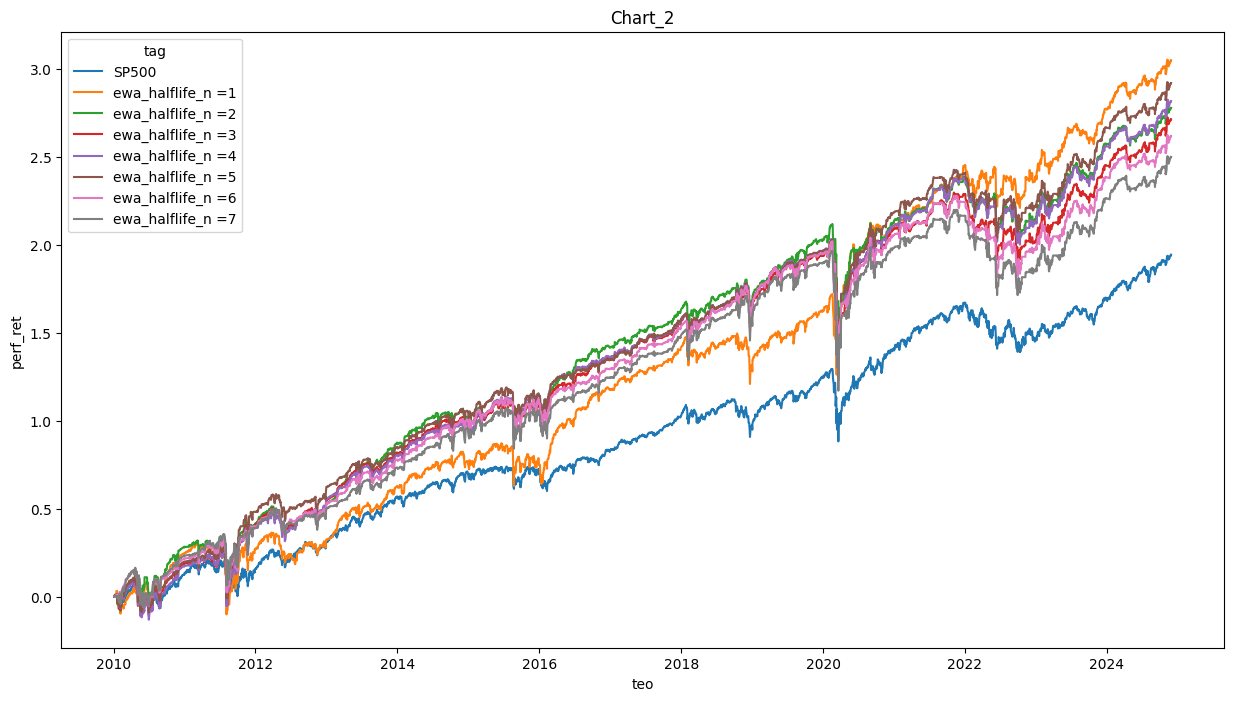

In [16]:
# Section 10: Visualization and Performance Comparison

print("\n📈 SECTION 10: VISUALIZATION AND PERFORMANCE ANALYSIS")
print("=" * 60)
print("\nxarray makes visualization incredibly easy with built-in plotting methods")

# 10.1 Cumulative Performance Chart
print("\n10.1 Creating cumulative performance chart...")

# Define analysis period (adjust dates as needed based on your data)
try:
    # Use full date range available in the data
    start_date = Results_xr['perf_ret'].teo.values[0].strftime('%Y-%m-%d')
    end_date = Results_xr['perf_ret'].teo.values[-1].strftime('%Y-%m-%d')
    print(f"Analysis period: {start_date} to {end_date}")
    
    # Calculate and plot cumulative returns
    cumulative_performance = (Results_xr['perf_ret']
                            .sel(teo=slice(start_date, end_date))
                            .cumsum(dim='teo'))
    
    # Create the plot using xarray's built-in plotting
    fig, ax = plt.subplots(figsize=(15, 8))
    
    cumulative_performance.plot.line(x='teo', ax=ax, linewidth=2)
    
    # Enhance the plot
    ax.set_title('Cumulative Strategy Performance Comparison\n'
               'Demonstrating Parameter Sensitivity in Financial Simulations', 
               fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Return', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add zero line for reference
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Cumulative performance chart created")
    print("  Key insights to look for:")
    print("    • Which EWM halflife parameter performs best?")
    print("    • How do strategies compare to buy-and-hold benchmark?")
    print("    • Are there periods where certain parameters excel?")
    print("    • What's the risk-return tradeoff across parameters?")

except Exception as e:
    print(f"Chart creation encountered an issue: {e}")
    print("This might be due to date range or data availability")
    
# 10.2 Performance Statistics Summary
print("\n10.2 Performance statistics summary:")

# Calculate key metrics for all strategies
metrics_summary = {}

for strategy in Results_xr.tag.values:
    strategy_returns = Results_xr['perf_ret'].sel(tag=strategy).dropna()
    
    metrics_summary[strategy] = {
        'Total Return': float(strategy_returns.sum()),
        'Annualized Return': float(strategy_returns.mean() * 252),
        'Volatility': float(strategy_returns.std() * np.sqrt(252)),
        'Sharpe Ratio': float((strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)),
        'Max Drawdown': float((strategy_returns.cumsum() - strategy_returns.cumsum().cummax()).min()),
        'Hit Rate': float((strategy_returns > 0).mean())
    }

# Convert to DataFrame for nice display
metrics_df = pd.DataFrame(metrics_summary).T
print("Strategy Performance Metrics:")
display(metrics_df.round(4))

In [17]:

# Section 11: Comprehensive Statistical Analysis

print("\n📊 SECTION 11: COMPREHENSIVE STATISTICAL ANALYSIS")
print("=" * 60)
print("\nUsing our custom sim_stats function to generate publication-ready")
print("performance statistics across all simulation runs")

# 11.1 Define Analysis Time Range
print("\n11.1 Setting analysis time range...")

# Use the full range available in the last simulation
trange = slice(regout_list[-1].index[0], regout_list[-1].index[-1])
print(f"Analysis period: {trange.start.date()} to {trange.stop.date()}")
print(f"Total trading days: {len(regout_list[-1])}")

# 11.2 Generate Comprehensive Statistics
print("\n11.2 Generating comprehensive performance statistics...")
print("This function calculates all the metrics that matter in quantitative finance:")

# Call our comprehensive statistics function
comprehensive_stats = sim_stats(
    regout_list=regout_list,
    sweep_tags=sweep_tags, 
    author='Financial Engineering Student',
    trange=trange
)

print("\n📋 Comprehensive Statistics Table:")
print("(All key metrics for academic and professional analysis)")

# Display the results with proper formatting
display(comprehensive_stats.round(4))

# 11.3 Insights and Interpretation Guide
print("\n11.3 How to interpret these statistics:")
print("\n🎯 KEY PERFORMANCE METRICS:")
print("  • return: Annualized portfolio return (252 trading days)")
print("  • stdev: Annualized volatility") 
print("  • sharpe: Risk-adjusted return (return/volatility)")
print("  • avg_beta: Average position size (leverage)")
print("  • beta_1_return: Return per unit of leverage")

print("\n🔍 PREDICTION ACCURACY:")
print("  • rmse: Root mean squared error of predictions")
print("  • mae: Mean absolute error")
print("  • r2: R-squared (explained variance)")
print("  • pos_bet_ratio: Fraction of positive predictions")

print("\n📈 BENCHMARK COMPARISON:")
print("  • benchmark return: Buy-and-hold SPY return")
print("  • benchmark std: Buy-and-hold SPY volatility") 
print("  • benchmark sharpe: Buy-and-hold risk-adjusted return")

print("\n📊 METADATA:")
print("  • beg_pred/end_pred: Simulation date range")
print("  • sim_time: When the simulation was run")
print("  • author: Who ran the simulation")

# 11.4 Performance Ranking
print("\n11.4 Strategy ranking by Sharpe ratio:")
sharpe_ranking = comprehensive_stats.loc['sharpe'].sort_values(ascending=False)
print("\nRank | Strategy | Sharpe Ratio")
print("-" * 35)
for i, (strategy, sharpe) in enumerate(sharpe_ranking.items(), 1):
    print(f"{i:2d}   | {strategy:<15} | {sharpe:8.3f}")

best_strategy = sharpe_ranking.index[0]
print(f"\n🏆 Best performing strategy: {best_strategy}")
print(f"   Sharpe ratio: {sharpe_ranking.iloc[0]:.3f}")
print(f"   Annualized return: {comprehensive_stats.loc['return', best_strategy]:.2%}")
print(f"   Volatility: {comprehensive_stats.loc['stdev', best_strategy]:.2%}")

SIMULATION RANGE:  from  2000-08-03 00:00:00 to  2025-04-07 00:00:00


,ewa_halflife_n =1,ewa_halflife_n =2,ewa_halflife_n =3,ewa_halflife_n =4,ewa_halflife_n =5,ewa_halflife_n =6,ewa_halflife_n =7
teo,,,,,,,
return,0.129281,0.127278,0.115437,0.110636,0.111914,0.105734,0.10093
stdev,0.267514,0.275753,0.277365,0.282408,0.284253,0.286627,0.286417
sharpe,0.483267,0.461566,0.416192,0.391759,0.393713,0.368891,0.352389
avg_beta,0.959878,0.943281,0.937077,0.934499,0.930551,0.922172,0.915888
beta_1_return,0.134685,0.134932,0.123188,0.118391,0.120267,0.114658,0.110199
pos_bet_ratio,0.533999,0.51853,0.514341,0.509507,0.51418,0.519497,0.526587
rmse,0.012132,0.012139,0.012153,0.012171,0.01217,0.012173,0.012176
mae,0.008056,0.00805,0.008047,0.00805,0.008046,0.008045,0.008044
r2,0.002871,0.001599,-0.000588,-0.003588,-0.003513,-0.003995,-0.004361


In [18]:
# Section 12: Feature Analysis and Model Insights

print("\n🔬 SECTION 12: FEATURE ANALYSIS AND MODEL INSIGHTS")
print("=" * 60)
print("\nAnalyzing which features drive our model performance over time")
print("This is crucial for understanding WHY our models work (or don't work)")

# 12.1 Annual Feature Correlation Analysis
print("\n12.1 Analyzing feature importance by year...")
print("This shows how factor relationships change across market regimes")

# Use the first feature set (most responsive) for analysis
feature_analysis = p_by_year(X_list[0], y_list[0], sort_by='p_value', t_list=None)

print("\n📊 Annual Feature Correlations with SPY Returns:")
print("(Shows how each sector's predictive power changes over time)")

# Display transposed for easier reading (years as columns)
annual_correlations = feature_analysis.T
display(annual_correlations.round(4))

# 12.2 Feature Insights
print("\n12.2 Key insights from feature analysis:")

# Find most consistently predictive features
avg_correlation = annual_correlations.mean()
most_predictive = avg_correlation.abs().sort_values(ascending=False)

print(f"\n🎯 Most predictive sectors (by average absolute correlation):")
for i, (sector, corr) in enumerate(most_predictive.head().items(), 1):
    print(f"  {i}. {sector}: {corr:.4f}")

# Analyze correlation stability
correlation_std = annual_correlations.std()
most_stable = correlation_std.sort_values(ascending=True)

print(f"\n📈 Most stable relationships (lowest correlation volatility):")
for i, (sector, std) in enumerate(most_stable.head().items(), 1):
    print(f"  {i}. {sector}: {std:.4f} (standard deviation)")

print(f"\n🔄 Most unstable relationships (highest correlation volatility):")
for i, (sector, std) in enumerate(most_stable.tail().items(), 1):
    print(f"  {i}. {sector}: {std:.4f} (standard deviation)")

# 12.3 Interpretation Guide
print(f"\n12.3 How to interpret these results:")
print("📖 CORRELATION INTERPRETATION:")
print("  • Positive values: Sector leads SPY in same direction")
print("  • Negative values: Sector moves opposite to SPY")  
print("  • Values near zero: Little predictive relationship")
print("  • High absolute values: Strong predictive relationship")

print("\n🔄 STABILITY INTERPRETATION:")
print("  • Low standard deviation: Consistent relationship across years")
print("  • High standard deviation: Relationship changes with market regimes")
print("  • This helps identify which factors are regime-dependent")

print("\n💡 PRACTICAL IMPLICATIONS:")
print("  • Stable, high-correlation sectors → Core model features")
print("  • Unstable relationships → Regime-switching indicators")
print("  • Sign changes over time → Potential structural breaks")
print("  • This analysis guides feature selection and model robustness")

from  2025-01-02 00:00:00  to  2025-04-07 00:00:00


Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
1998,-0.587210,-0.374294,-0.506994,-0.280492,-0.177197,-0.502744,-0.209148,-0.700171,-0.533026
1999,-0.071519,-0.061252,0.059149,-0.018341,-0.044764,0.011468,-0.058285,-0.005569,-0.027985
2000,0.044946,0.036438,0.015815,-0.081600,-0.095882,-0.006675,0.004315,-0.038148,-0.002018
2001,-0.010815,0.052548,-0.083981,-0.033722,-0.045207,0.037237,-0.020312,-0.013132,-0.005674
2002,-0.054589,-0.048429,-0.056093,-0.064544,-0.045041,-0.013822,-0.054438,-0.003021,-0.063441
2003,-0.088468,-0.078263,-0.047911,-0.057864,-0.050468,0.007877,-0.014729,-0.175393,-0.060857
2004,0.069259,-0.052878,-0.029115,0.028633,-0.026441,-0.032288,0.034724,-0.049986,0.018488
2005,-0.032689,-0.025743,-0.101314,-0.091652,-0.041514,-0.177229,-0.157255,-0.128898,-0.093580
2006,-0.092085,-0.107380,-0.057890,-0.032647,0.037901,-0.070698,-0.107961,-0.064684,-0.013032
2007,-0.186103,-0.280784,-0.065470,-0.110744,-0.119056,-0.051921,-0.105277,-0.044397,-0.061188


In [19]:
# Section 13: Conclusion and Next Steps

print("\n🎓 SECTION 13: CONCLUSION AND LEARNING SUMMARY")
print("=" * 60)
print("\nCongratulations! You've completed a comprehensive quantitative finance simulation.")

print("\n📚 WHAT YOU'VE LEARNED:")
print("\n1. 🕒 TIME SERIES SIMULATION FUNDAMENTALS:")
print("   • Walk-forward analysis prevents look-ahead bias")
print("   • Proper train/test temporal split methodology")
print("   • Rolling vs expanding window considerations")
print("   • Time zone handling for global financial data")

print("\n2. 🧮 MACHINE LEARNING FOR FINANCE:")
print("   • sklearn pipeline construction for reproducibility")
print("   • Custom transformers for financial data (EWM smoothing)")
print("   • Integration of statsmodels with sklearn framework")
print("   • Parameter sensitivity analysis through systematic sweeps")

print("\n3. 📊 XARRAY FOR RESEARCH ORGANIZATION:")
print("   • Multi-dimensional data structure for results")
print("   • Labeled dimensions for self-documenting code")
print("   • Vectorized operations across strategies and time")
print("   • Easy visualization and statistical analysis")

print("\n4. 📈 QUANTITATIVE FINANCE CONCEPTS:")
print("   • Log returns vs simple returns")
print("   • Position sizing and leverage management")
print("   • Risk-adjusted performance metrics (Sharpe ratio)")
print("   • Feature analysis and regime detection")
print("   • Benchmark comparison and alpha generation")

print("\n🚀 NEXT STEPS FOR ADVANCED STUDENTS:")
print("\n📖 EXTENSIONS TO EXPLORE:")
print("   1. Add transaction costs and market impact models")
print("   2. Implement dynamic position sizing based on volatility")
print("   3. Explore alternative ML models (Random Forest, XGBoost)")
print("   4. Add regime detection and switching models")
print("   5. Implement portfolio optimization constraints")
print("   6. Add factor analysis and risk attribution")
print("   7. Explore alternative data sources (sentiment, macro)")

print("\n🔬 RESEARCH DIRECTIONS:")
print("   1. Study parameter stability across market cycles")
print("   2. Investigate feature engineering techniques")
print("   3. Analyze model degradation over time")
print("   4. Compare different rebalancing frequencies")
print("   5. Study correlation structure changes")

print("\n💼 PROFESSIONAL APPLICATIONS:")
print("   • Portfolio management and optimization")
print("   • Risk management system development")  
print("   • Alpha research and strategy development")
print("   • Model validation and backtesting frameworks")
print("   • Performance attribution analysis")

print("\n🎯 KEY TAKEAWAYS:")
print("   ✓ Time series simulations require careful temporal structure")
print("   ✓ xarray dramatically simplifies multi-dimensional financial analysis")
print("   ✓ sklearn pipelines enable reproducible financial research")
print("   ✓ Parameter sweeps reveal model sensitivity and robustness")
print("   ✓ Feature analysis guides model interpretation and improvement")

print("\n" + "="*60)
print("📝 SAVE YOUR WORK AND EXPERIMENT!")
print("This framework provides a solid foundation for your own research.")
print("Modify parameters, try different models, and explore new ideas!")
print("="*60)

# Generate requirements file for reproducibility
print("\n💾 Generating requirements.txt for reproducibility...")
import subprocess
import sys

try:
    result = subprocess.run([sys.executable, "-m", "pip", "freeze"], 
                          capture_output=True, text=True, check=True)
    
    with open('requirements.txt', 'w') as f:
        f.write(result.stdout)
    
    print("✅ requirements.txt generated successfully!")
    print("   Use 'pip install -r requirements.txt' to recreate this environment")
    
except Exception as e:
    print(f"⚠️  Could not generate requirements.txt: {e}")
    print("   You can manually run: pip freeze > requirements.txt")